In [15]:
import os
import sqlite3
import tempfile
import json
import requests
from fake_useragent import UserAgent
from openai import OpenAI
import moviepy.editor as mp
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.schema import Document

DATABASE_PATH = '/Users/mins/Desktop/github/bilibili_summarize/db/sqlite/bilibili.db'
BASE_URL = '/Users/mins/Desktop/github/bilibili_summarize/static'
COOKIE_PATH = '/Users/mins/Desktop/github/bilibili_summarize/cookie/cookie.json'

class DyanmicTools:
    def video_2_audio(self, id: str):
        try:
            videos_path = os.path.join(BASE_URL, 'video', f"{id}.mp4")
            audio_path = os.path.join(BASE_URL, 'audio', f"{id}.mp3")

            conn = sqlite3.connect(DATABASE_PATH)
            cursor = conn.cursor()

            cursor.execute("SELECT COUNT(*) FROM dynamic WHERE id = ?", (id,))
            exists = cursor.fetchone()[0]

            my_clip = mp.VideoFileClip(videos_path)
            my_clip.audio.write_audiofile(audio_path)

            with open(audio_path, 'rb') as audio_file:
                audio_bytes = audio_file.read()

            if exists:
                cursor.execute("UPDATE dynamic SET audio = ? WHERE id = ?", (audio_bytes, id))
            else:
                cursor.execute("INSERT INTO dynamic (id, audio) VALUES (?, ?)", (id, audio_bytes))

            conn.commit()
            conn.close()
        except FileNotFoundError as e:
            raise FileNotFoundError(f"文件未找到: {e}")
        except Exception as e:
            raise Exception(f"发生错误: {e}")

    def audio_2_content(self, id: str):
        if not id:
            raise ValueError("id 未提供")

        client = OpenAI()

        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        cursor.execute("SELECT audio FROM dynamic WHERE id = ?", (id,))
        audio_data = cursor.fetchone()

        if audio_data is None:
            raise ValueError("未找到音频数据")

        temp_audio_file_path = None
        try:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as temp_audio_file:
                temp_audio_file.write(audio_data[0])
                temp_audio_file_path = temp_audio_file.name

            with open(temp_audio_file_path, "rb") as audio_file:
                transcript = client.audio.transcriptions.create(
                    model="whisper-1",
                    file=audio_file,
                    response_format="json"
                )
            print(transcript)
            content = transcript.text

            cursor.execute("UPDATE dynamic SET content = ? WHERE id = ?", (content, id))
            conn.commit()
        except Exception as e:
            raise Exception(f"OpenAI API 错误: {e}")
        finally:
            if temp_audio_file_path:
                os.remove(temp_audio_file_path)
            conn.close()

    def content_2_summary(self, id: str):
        if not id:
            raise ValueError("id 未提供")

        try:
            prompt_template = """
            Write a concise summary of the following:
            "{text}"
            CONCISE SUMMARY，请用简体中文回答:
            """
            prompt = PromptTemplate.from_template(prompt_template)

            llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
            llm_chain = LLMChain(llm=llm, prompt=prompt)
            stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

            conn = sqlite3.connect(DATABASE_PATH)
            cursor = conn.cursor()
            cursor.execute("SELECT content FROM dynamic WHERE id = ?", (id,))
            text = cursor.fetchone()

            if text is None:
                raise ValueError("未找到文本数据")

            documents = [Document(page_content=text[0])]
            summary = stuff_chain.invoke(documents)["output_text"]
            print(summary)
            cursor.execute("UPDATE dynamic SET summary = ? WHERE id = ?", (summary, id))
            conn.commit()
        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found error: {e}")
        except IOError as e:
            raise IOError(f"IO error: {e}")
        except Exception as e:
            raise Exception(f"发生错误: {e}")
        finally:
            conn.close()

    def sent_bilibili_dynamic(self, id: str):
        if not id:
            raise ValueError("id 未提供")

        try:
            with open(COOKIE_PATH, 'r') as file:
                cookie = dict(json.load(file))
        except FileNotFoundError:
            raise FileNotFoundError("未查询到用户文件，请确认资源完整")
        except json.JSONDecodeError:
            raise ValueError("用户文件格式错误")

        ua = UserAgent()
        url = "https://api.vc.bilibili.com/dynamic_svr/v1/dynamic_svr/create"
        headers = {
            "Content-Type": "application/x-www-form-urlencoded",
            "User-Agent": ua.random,
            "Cookie": "; ".join([f"{key}={value}" for key, value in cookie.items()])
        }

        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        cursor.execute("SELECT summary FROM dynamic WHERE id = ?", (id,))
        summary = cursor.fetchone()[0]
        print(summary)
        content = f"https://www.bilibili.com/video/{id}\n{summary}"
        data = {
            "type": 4,
            "rid": 0,
            "content": content
        }

        try:
            response = requests.post(url, headers=headers, data=data)
            response.raise_for_status()
            cursor.execute("UPDATE dynamic SET is_sent = ? WHERE id = ?", (1, id))
            conn.commit()
        except requests.RequestException as e:
            raise Exception(f"动态发布失败，错误信息: {str(e)}")
        except Exception as e:
            raise Exception(f"发生错误: {e}")
        finally:
            conn.close()

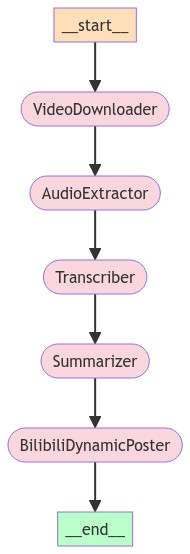

{'VideoDownloader': {'video': '已完成'}}
----
MoviePy - Writing audio in /Users/mins/Desktop/github/bilibili_summarize/static/audio/BV1AS421N7Rc.mp3


MoviePy - Done.
{'AudioExtractor': {'audio': '已完成'}}
----
Transcription(text='讓人們聞之色變的法家思想 曾提出了一個驚世駭俗的結論 他認為百姓根本分不清楚善惡 所謂的善惡只是某些人的工具 他認為百姓根本分不清楚好壞 所謂的好壞要由他們來決定 大家好我是白龍雪 今天要說的就是 法家的真相 在戰國時期 韓非子研究列國強弱的原因時 曾得出了一個極為冷門的結論 他說古秦之俗 君臣廢法而服私 是以國亂兵弱而主卑 這什麼意思呢 什麼是廢法而服私呢 在韓非看來 一群人之所以能組成一個部落 創建出一個國家 必然要遵守一些大家公認 且能夠執行的規則 這就像是班級中的班規 公司裏的制度一樣 所謂的廢法而服私 就是這個制度變成了擺設 決定權去了個人手裏 就是掌握法令的地方貴族 如果不願意懲罰一個人 那他就可以利用赦免的方式 給犯人一個改過自新的機會 如果這些貴族真的想要懲罰一個人 那他就可以用株連九族 酷刑連坐的方式 直接給這個犯人滿門抄斬 也就是說 判斷一個人是否觸犯了法令 不在於法令本身的條款 而在於他有沒有觸犯掌握法令的人 而且矛盾的就是 隨意的赦免某個人 百姓不會認為這是在貪贓枉法 反而還覺得貴族寬厚仁慈 體恤下情 隨意的屠殺某個人 百姓也不會認為這是嚴刑峻法 反而還覺得是這個犯人罪有應得 認為他是自討苦吃 為什麼會這樣呢 為什麼百姓分不清楚善惡呢 因為對什麼是善 什麼是惡的定義 從來就不需要參考尋常百姓的意見 他們只需要告訴百姓什麼是善 什麼是惡 只需要將觸犯法令的人 放在這個善惡的標準之中 只需要讓百姓看見他善 或者是惡的一面 這個概念可能有些難以理解 我們再換個說法 比如說有兩個人 一個是大家眼中的好人 善人 是當地遠近農民的慈善大家 另一個是大家眼中的壞人 惡人 是當地遠近農民的無業農民 如果這兩個人 都觸犯了同一條法令 接下來要面對相同的懲罰 很多人就會覺得不公平 因為在我們常識中認為 好人犯錯時另有隱情 善惡都要同罪同罰 那以後人們為什麼還要行善呢 說這樣只是看起來公平 實際上是最大的不公平 但問題就是 這個好壞是由誰來決定的呢 如果故事中的好人 背地裏做著傷天害理的勾當 只是一個道貌岸然的好人呢 如果故事中的壞人 背地裏做著樂善好施的行為 只是一個不善於表達的人呢 所以在韓非子看來 人心四

In [19]:

from typing import TypedDict
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain.schema import Document

from fake_useragent import UserAgent
from openai import OpenAI

# from tools import DyanmicTools

import moviepy.editor as mp
import os
import json
import requests
import sqlite3
import tempfile

DATABASE_PATH = '/Users/mins/Desktop/github/bilibili_summarize/db/sqlite/bilibili.db'
BASE_URL = '/Users/mins/Desktop/github/bilibili_summarize/static'
COOKIE_PATH = '/Users/mins/Desktop/github/bilibili_summarize/cookie/cookie.json'

class MyState(TypedDict):
    id: str
    video: str
    audio: str
    content: str
    summary: str
    dynamic: bool

dyanmicTools = DyanmicTools()
def download_video_node(state: MyState):
    # 下载视频
    return {"video": "已完成"}

def video_2_audio_node(state: MyState):
    # 视频转音频
    id = state["id"]
    try:
        dyanmicTools.video_2_audio(id)
        return {"audio": "已完成"}
    except Exception as e:
        return {"audio": e}

def audio_2_content_node(state: dict):
    # 音频转换为文本
    id = state["id"]
    try:
        dyanmicTools.audio_2_content(id)
        return {"content": "已完成"}
    except Exception as e:
        return {"content": e}

def content_2_summary_node(state: MyState):
    # 文本摘要
    id = state["id"]
    try:
        dyanmicTools.content_2_summary(id)
        return {"summary": "已完成"}
    except Exception as e:
        return {"summary": e}

def sent_bilibili_dynamic_node(state: MyState):
    # 发布 bilibili 动态
    id = state["id"]
    try:
        dyanmicTools.sent_bilibili_dynamic(id)
        return {"dynamic": "已完成"}
    except Exception as e:
        return {"dynamic": e}


workflow = StateGraph(MyState)
workflow.add_node("VideoDownloader", download_video_node)
workflow.add_node("AudioExtractor", video_2_audio_node)
workflow.add_node("Transcriber", audio_2_content_node)
workflow.add_node("Summarizer", content_2_summary_node)
workflow.add_node("BilibiliDynamicPoster", sent_bilibili_dynamic_node)

workflow.set_entry_point("VideoDownloader")
workflow.add_edge("VideoDownloader", "AudioExtractor")
workflow.add_edge("AudioExtractor", "Transcriber")
workflow.add_edge("Transcriber", "Summarizer")
workflow.add_edge("Summarizer", "BilibiliDynamicPoster")
workflow.add_edge("BilibiliDynamicPoster", END)

# 编译工作流图
graph = workflow.compile()

from IPython.display import Image, display
# 画出工作流图
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

input = {
    "id":"BV1AS421N7Rc",
    "video": "未完成",
    "audio": "未完成",
    "content": "未完成",
    "summary": "未完成",
    "dynamic": False,
}
# 执行工作流图，流式输出
events = graph.stream(input)
for s in events:
    print(s)
    print("----")